# Mathematical Foundations of Computer Graphics and Vision 2022
## Exercise 2 - Global Optimization

In [1]:
%matplotlib inline
import math
import numpy as np
from scipy.optimize import linprog
from scipy.io import loadmat
from matplotlib.lines import Line2D  
import matplotlib.pyplot as plt

## A. Problem Reformulation
see the report

## Define Problem Class

In [2]:
class Problem():
    def __init__(self, ThetaLowerBound, ThetaUpperBound, left_points, right_points, delta, ObjLowerBound = 0, ObjUpperBound = 0, ThetaOptimizer = (0, 0)):
        self.ThetaLowerBound = ThetaLowerBound
        self.ThetaUpperBound = ThetaUpperBound
        self.left_points = left_points
        self.right_points = right_points
        self.delta = delta
        self.ObjLowerBound = ObjLowerBound 
        self.ObjUpperBound = ObjUpperBound
        self.ThetaOptimizer = ThetaOptimizer
        self.linear_programming()
        
    def __str__(self):
        return (
            "ThetaLowerBound: " + str(self.ThetaLowerBound) + "\n" +
            "ThetaUpperBound: " + str(self.ThetaUpperBound) + "\n" +
            "ObjLowerBound: " + str(self.ObjLowerBound) + "\n" +
            "ObjUpperBound: " + str(self.ObjUpperBound) + "\n" +
            "ThetaOptimizer: " + str(self.ThetaOptimizer) + "\n"
        )
    def __gt__(self, x):
        return (self.ObjUpperBound > x. ObjUpperBound) if self.ObjLowerBound == x.ObjLowerBound else (self.ObjLowerBound > x.ObjLowerBound)
    
    def is_feasible(self, optimal_solution):
        return self.ObjUpperBound >= optimal_solution["bound"][0]
    
    def is_better(self, optimal_solution):
        return self.ObjLowerBound >= optimal_solution["bound"][0]
    
    def get_inlier_mask(self):
        return np.logical_and(
            np.abs(self.left_points[:, 0] + self.ThetaOptimizer[0] -  self.right_points[:, 0]) <= self.delta,
            np.abs(self.left_points[:, 1] + self.ThetaOptimizer[1] -  self.right_points[:, 1]) <= self.delta
        )
    
    def get_lower_bound(self):
        is_inlier = self.get_inlier_mask()
        return left_points[is_inlier].shape[0]
        
    
    def linear_programming(self):
        n = left_points.shape[0]
        identity = np.identity(n)
        zeros = np.zeros((n, n))
        ones = np.ones((n, 1))

        A = np.r_[
            np.c_[
                self.ThetaLowerBound[0]*identity, -identity, zeros, zeros[:, :2]
            ],
            np.c_[
                self.ThetaUpperBound[0]*identity, -identity, zeros, ones, zeros[:, 0]
            ],
            np.c_[
                -self.ThetaLowerBound[0]*identity, identity, zeros, -ones, zeros[:, 0]
            ],
            np.c_[
                -self.ThetaUpperBound[0]*identity, identity, zeros, zeros[:, :2]
            ],

            np.c_[
                self.ThetaLowerBound[1]*identity, zeros, -identity, zeros[:, :2]
            ],
            np.c_[
                self.ThetaUpperBound[1]*identity, zeros, -identity, zeros[:, 0], ones
            ],
            np.c_[
                -self.ThetaLowerBound[1]*identity, zeros, identity, zeros[:, 0], -ones
            ],
            np.c_[
                -self.ThetaUpperBound[1]*identity, zeros, identity, zeros[:, :2]
            ],

            np.c_[
                np.diag(self.left_points[:, 0] - self.right_points[:, 0] - self.delta), identity, zeros, zeros[:, :2]
            ],
            np.c_[
                np.diag(-self.left_points[:, 0] + self.right_points[:, 0] - self.delta), -identity, zeros, zeros[:, :2]
            ],
            np.c_[
                np.diag(self.left_points[:, 1] - self.right_points[:, 1] - self.delta), zeros, identity, zeros[:, :2]
            ],
            np.c_[
                np.diag(-self.left_points[:, 1] + self.right_points[:, 1] - self.delta), zeros, -identity, zeros[:, :2]
            ]
        ]
        b = np.r_[
            zeros[:, 0, np.newaxis], self.ThetaUpperBound[0] * ones, -self.ThetaLowerBound[0] * ones, zeros[:, 0, np.newaxis],
            zeros[:, 0, np.newaxis], self.ThetaUpperBound[1] * ones, -self.ThetaLowerBound[1] * ones, zeros[:, 0, np.newaxis],
            zeros[:, 0, np.newaxis], zeros[:, 0, np.newaxis], zeros[:, 0, np.newaxis], zeros[:, 0, np.newaxis]
        ]
        c = np.r_[-ones, zeros[:, 0, np.newaxis], zeros[:, 0, np.newaxis], np.zeros((2,1))]

        lb = np.r_[zeros[:, 0, np.newaxis], -np.Inf * ones, -np.Inf * ones, self.ThetaLowerBound[0]*np.ones((1,1)), self.ThetaLowerBound[1]*np.ones((1,1))]
        ub = np.r_[ones, np.Inf * ones, np.Inf * ones, self.ThetaUpperBound[0]*np.ones((1,1)), self.ThetaUpperBound[1]*np.ones((1,1))]
        bounds = []
        for pair in zip(lb.tolist(), ub.tolist()):
            bounds.append((pair[0][0], pair[1][0]))

        res = linprog(c, A_ub = A, b_ub = b, bounds = bounds, method="highs-ds")
        
        self.ThetaOptimizer = (res.x[-2], res.x[-1])
        self.ObjUpperBound = -res.fun
        self.ObjLowerBound = self.get_lower_bound()
    
    def split(self):
        (tx_lo, ty_lo), (tx_hi, ty_hi) = self.ThetaLowerBound, self.ThetaUpperBound
        left_problem = None
        right_problem = None
        if tx_hi - tx_lo > ty_hi - ty_lo:
            mid = (tx_hi + tx_lo)/2
            left_problem = Problem((tx_lo, ty_lo), (math.floor(mid), ty_hi), self.left_points, self.right_points, self.delta)
            right_problem = Problem((math.ceil(mid), ty_lo), (tx_hi, ty_hi), self.left_points, self.right_points, self.delta)
        else:
            mid = (ty_hi + ty_lo)/2
            left_problem = Problem((tx_lo, ty_lo), (tx_hi, math.floor(mid)), self.left_points, self.right_points, self.delta)
            right_problem = Problem((tx_lo, math.ceil(mid)), (tx_hi, ty_hi), self.left_points, self.right_points, self.delta)
        return left_problem, right_problem

## Load Data

In [3]:
left_img = plt.imread('../data/InputLeftImage.png')
right_img = plt.imread('../data/InputRightImage.png')
IMG_H, IMG_W, _ = left_img.shape
delta = 3
padding = 10
corr_list = loadmat('../data/ListInputPoints.mat')['ListInputPoints']
left_points, right_points = corr_list[:, 0:2], corr_list[:, 2:4]

## Initialization

In [4]:
problem_0 = Problem((-IMG_H, -IMG_W), (IMG_H, IMG_W), left_points, right_points, delta)
print(problem_0)
problem_list = []
problem_list.append(problem_0)

optimal_solution = {"bound":(-np.Inf, np.Inf), "theta":(0, 0)}
optimal_problem = problem_0
history = []
history.append((problem_0.ObjLowerBound, problem_0.ObjUpperBound))

ThetaLowerBound: (-549, -1104)
ThetaUpperBound: (549, 1104)
ObjLowerBound: 0
ObjUpperBound: 33.664711580144065
ThetaOptimizer: (-173.70230500582068, -60.09667054714782)



## B. Branch and Bound
The code implementing branch and bound for consensus set maximization with a 2D translation model

In [5]:
while(len(problem_list) > 0):
    current_problem = problem_list.pop()
    if not current_problem.is_feasible(optimal_solution):
        continue
    if current_problem.is_better(optimal_solution):
        optimal_solution["bound"] = (current_problem.ObjLowerBound, current_problem.ObjUpperBound)
        optimal_solution["theta"] = current_problem.ThetaOptimizer
        optimal_problem = current_problem
    highest_upperbound = 0
   
    history.append(optimal_solution["bound"])
    
    if current_problem.ObjUpperBound - current_problem.ObjLowerBound < 1:
        continue
        
    left_problem, right_problem = current_problem.split()
    if left_problem > right_problem:
        problem_list.append(right_problem)
        problem_list.append(left_problem)
    else:
        problem_list.append(left_problem)
        problem_list.append(right_problem)    

## C. Results 
Including the results of the translation model (ThetaOptimizer), and the indices of the inliers and outliers obtained by branch and bound

In [6]:
print(optimal_problem)
is_inlier = optimal_problem.get_inlier_mask()
print("Inlier indices: ")
print([i for i, x in enumerate(is_inlier) if x])
print("Outlier indices: ")
print([i for i, x in enumerate(is_inlier) if not x])

ThetaLowerBound: (-274, -276)
ThetaUpperBound: (0, 0)
ObjLowerBound: 15
ObjUpperBound: 15.866963107682938
ThetaOptimizer: (-232.0, -154.0)

Inlier indices: 
[2, 7, 8, 14, 15, 19, 25, 30, 31, 33, 34, 39, 41, 44, 50]
Outlier indices: 
[0, 1, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 32, 35, 36, 37, 38, 40, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 54]


## D. Correspondences Figure
A figure showing the identified inlier and outlier correspondences

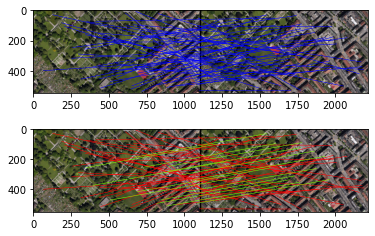

In [7]:
# image = np.c_[left_img, np.zeros((IMG_H, padding, 3)), right_img]
image = np.hstack((left_img, np.zeros((IMG_H, padding, 3)), right_img))
left_points_plt = left_points
right_points_plt = right_points + np.array([IMG_W, 0]) + np.array([padding, 0])
left_inliers = left_points_plt[is_inlier]
right_inliers = right_points_plt[is_inlier]
left_outliers = left_points_plt[~is_inlier]
right_outliers = right_points_plt[~is_inlier]

ax1 = plt.subplot(211)
for coor in zip(left_points_plt, right_points_plt):
    line = Line2D((coor[0][0], coor[1][0]), (coor[0][1], coor[1][1]), linewidth = 0.5, color = "blue")
    ax1.add_line(line)
ax1.imshow(image)

ax2 = plt.subplot(212)
for coor in zip(left_outliers, right_outliers):
    line = Line2D((coor[0][0], coor[1][0]), (coor[0][1], coor[1][1]), linewidth = 0.5, color = "red")
    ax2.add_line(line)
for coor in zip(left_inliers, right_inliers):
    line = Line2D((coor[0][0], coor[1][0]), (coor[0][1], coor[1][1]), linewidth = 0.5, color = "lawngreen")
    ax2.add_line(line)
ax2.imshow(image)    
plt.savefig('coor.png', dpi=300)

## E. Cardinality Bounds Figure 
A figure showing the convergence of the cardinality bounds i.e. the highest lower bound obtained so far, and the highest upper bound still in the list. 

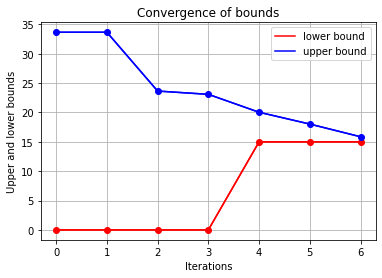

In [8]:
x_list = np.arange(0, len(history))
y_1 = [x[0] for x in history ]
y_2 = [x[1] for x in history ]

x_list = np.arange(0, len(history))

l1 = plt.plot(x_list, y_1, 'r-', label='lower bound')
l2 = plt.plot(x_list, y_2, 'b-', label='upper bound')

plt.plot(x_list, y_1, 'ro-', x_list, y_2, 'bo-')
plt.title('Convergence of bounds')
plt.xlabel('Iterations')
plt.ylabel('Upper and lower bounds')
plt.grid(visible=True)
plt.legend()
plt.savefig('conv.png', dpi=300)
plt.show()